# Stock Valuation - Nike Inc.

This notebook shows how to use the `value-investing-in-python` project to create a simple stock valuation. The evaluated stock (`Nike`, yahoo ticker: `NKE`) was chosen because of personal interest.

## Preliminaries

In [1]:
import pandas as pd

The following commands are necessary to use the 'value-investing-in-python' project as package.

In [2]:
import sys
sys.path.append('../')
sys.path.append('../src')

## Get data

In [3]:
from database.morningstar_scraper import MorningstarScraper
from database.yahoo_finance_scraper import YahooFinanceScraper
from database.damodaran_scraper import DamodaranScraper

In [4]:
from utils.data_interval import DataInterval

Scraping the **Morningstar identifier** does not work properly because of the dynamic JavaScript content on the webpage. Hence, identifier has to be extracted manually by inspecting the page content.

In [5]:
# morningstar_identfier = MorningstarScraper.scrape_morningstar_stock_identifier('NKE', 'XNYS')

In [6]:
morningstar_dataset = MorningstarScraper.scrape_and_combine_morningstar_data('0P000003X1', 20.0)

Scrape price data for Nike stock and the S&P 500 (benchmark):

In [7]:
one_day_interval = DataInterval.ONE_DAY

In [8]:
nke_prices = YahooFinanceScraper.scrape_price_data('NKE', 'max', one_day_interval)

In [9]:
sp500_prices = YahooFinanceScraper.scrape_price_data('^GSPC', 'max', one_day_interval)

Scrape data provided by Prof. Damodaran:

In [10]:
spreads, risk_premiums = DamodaranScraper.scrape_data()

In [11]:
spreads_nonfin, spreads_fin, premiums = DamodaranScraper.modify_damodaran_data(spreads, risk_premiums)

## Evaluate data

In [15]:
from evaluation.evaluator import Evaluator

In [16]:
from utils.assessment_period import AssessmentPeriod

### Plot metric development

In [17]:
ten_years_period = AssessmentPeriod.TEN_YEARS

In [20]:
morningstar_dataset_transposed = morningstar_dataset.T

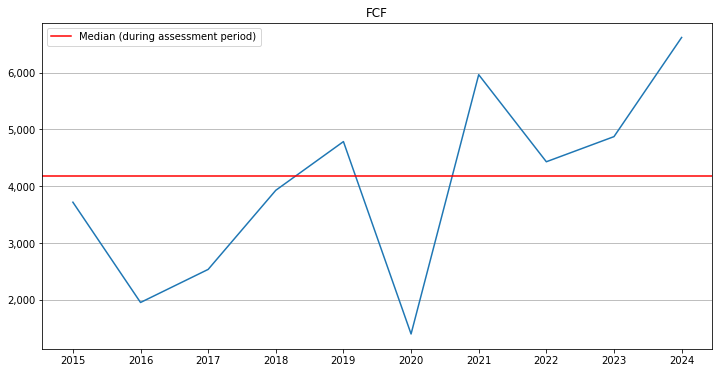

In [21]:
Evaluator.plot_metric_development(morningstar_dataset_transposed['free_cash_flow_mil'], ten_years_period, 'FCF')

In [22]:
margins = [morningstar_dataset_transposed['gross_margin_pct'], morningstar_dataset_transposed['net_margin_pct'],
           morningstar_dataset_transposed['operating_margin_pct']]

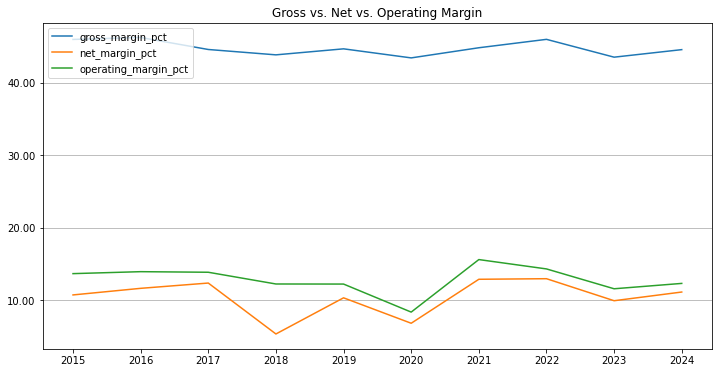

In [23]:
Evaluator.plot_metric_development_comparison(margins, ten_years_period, 'Gross vs. Net vs. Operating Margin')

In [24]:
returns = [morningstar_dataset_transposed['return_on_assets_pct'], morningstar_dataset_transposed['return_on_equity_pct'],
           morningstar_dataset_transposed['return_on_invested_capital_pct']]

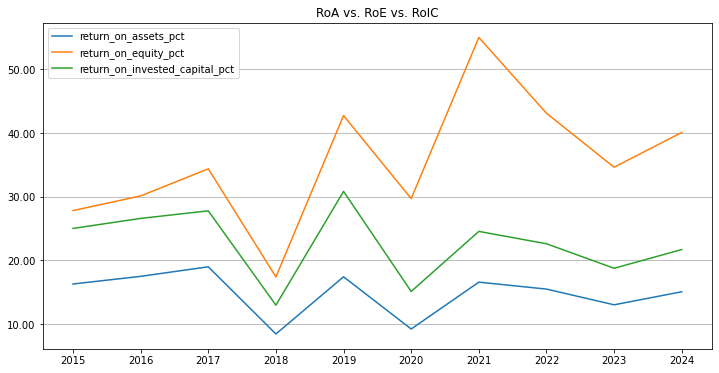

In [25]:
Evaluator.plot_metric_development_comparison(returns, ten_years_period, 'RoA vs. RoE vs. RoIC')

### Assess metric development

In [26]:
median_growth_rates, median_values = Evaluator.assess_metrics(morningstar_dataset_transposed)

In [27]:
median_growth_rates.round(3)

,10Y,3Y,1Y,points
revenue_mil,0.063,0.049,0.003,3
operating_income_mil,0.055,-0.034,0.067,2
net_income_mil,0.072,-0.015,0.124,2
eps,0.084,0.006,0.155,3
dividends,NaN,NaN,NaN,0
bvps,0.034,0.042,-0.002,2
operating_cash_flow_mil,0.070,0.082,0.272,3
free_cash_flow_mil,0.100,0.068,0.358,3
capex_mil,-0.033,0.072,-0.162,1


In [28]:
median_values.round(2)

,10Y,3Y,1Y,points
payout_ratio,32.05,38.04,NaN,2
interest_coverage_ratio,NaN,NaN,NaN,0
operating_margin_pct,12.96,12.29,12.29,3
net_margin_pct,10.90,11.10,11.10,3
gross_margin_pct,44.62,44.56,44.56,3
return_on_equity_pct,34.51,40.09,40.09,3
return_on_assets_pct,15.89,15.07,15.07,3
return_on_invested_capital_pct,23.58,21.70,21.70,3
free_cash_flow_to_revenue,10.15,9.51,12.88,3
current_ratio,2.58,2.63,2.40,3


### Cumulative returns (during last year)

In [29]:
from beta.beta_estimator import BetaEstimator

In [30]:
nke_returns_last_year = BetaEstimator.calculate_cumulative_returns(nke_prices[-253:])

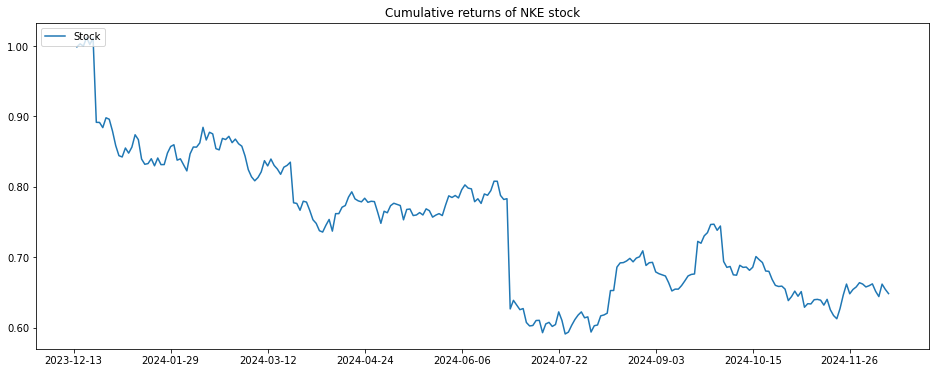

In [31]:
Evaluator.plot_cumulative_returns('NKE', nke_returns_last_year)

## Estimate intrinsic value

In [32]:
from intrinsic_value.discount_rate_estimator import DiscountRateEstimator
from intrinsic_value.growth_rate_calculator import GrowthRateCalculator
from intrinsic_value.intrinsic_value_estimator import IntrinsicValueEstimator

In [33]:
from utils.company_type import CompanyType
from utils.company_region import CompanyRegion
from utils.data_frequency import DataFrequency

### Beta estimation

In [34]:
daily_data = DataFrequency.DAILY

In [35]:
nke_beta = BetaEstimator.estimate_beta(nke_prices, sp500_prices, ten_years_period, daily_data)

In [36]:
nke_beta

1.015141245527783

### Discount rate estimation

In [37]:
nke_comp_type = CompanyType.NON_FINANCIAL

In [38]:
nke_comp_region = CompanyRegion.NORTH_AMERICA

In [39]:
discount_rate = DiscountRateEstimator.estimate_discount_rate(morningstar_dataset_transposed, spreads_nonfin, spreads_fin,
                                                             premiums, 0.0, nke_beta, nke_comp_type, nke_comp_region,
                                                             ten_years_period)

At least one input factors is NaN. Discount rate = NaN.


In [40]:
discount_rate

nan

Estimated discount rate is NaN, because the interest coverage ratio is NaN (no data provided by Morningstar).

### Growth rate estimation

In [41]:
free_cash_flow_series = morningstar_dataset_transposed['free_cash_flow_mil']

In [42]:
growth_rate = GrowthRateCalculator.calculate_median_cagr(free_cash_flow_series, ten_years_period)

In [43]:
print(f'Growth rate is {round(growth_rate * 100.0, 0)} %')

Growth rate is 10.0 %


### Intrinsic value

In [44]:
current_shares = morningstar_dataset_transposed['shares_mil'].iloc[-1]

In [45]:
disc_rates = [0.06, 0.07, 0.08, 0.09, 0.10]

In [46]:
terminal_gr = 0.02

In [47]:
intrinsic_values = IntrinsicValueEstimator.apply_discounted_cash_flow_model(free_cash_flow_series, current_shares,
                                                                            growth_rate, disc_rates, terminal_gr, 10)

Add column with intrinsic value reduced by 20 percent margin of safety:

In [48]:
intrinsic_values['IV after MoS'] = intrinsic_values['IV_DCF'] * 0.8

In [49]:
intrinsic_values

,IV_DCF,IV after MoS
6.0 %,125.860499,100.688399
7.0 %,97.165415,77.732332
8.0 %,78.289211,62.631369
9.0 %,64.999037,51.999229
10.0 %,55.181229,44.144983


Inspect the intrinsic value and the price development over the last year.

Latest adjusted close price: 77.25

Intrinsic value (after Margin of Safety): 100.69

Stock is undervalued! Difference is equal to: 23.44


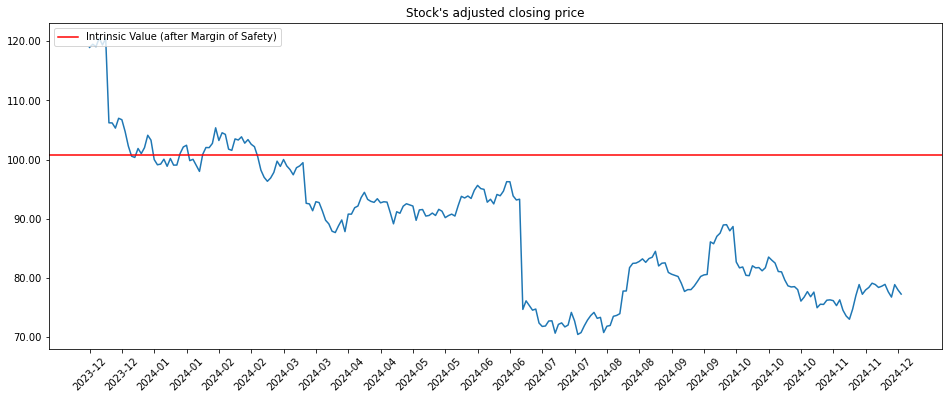

In [50]:
Evaluator.assess_intrinsic_value(nke_prices[-252:], intrinsic_values.iloc[0, 1], 0.2)

### Scores

In [51]:
hrlr_score = Evaluator.get_hrlr_score(nke_prices, sp500_prices, 0.0)

1-Year Beta: -0.96
Momentum: -35.08%
1-Year Dividend Yield: 0.0%
Overall score: 1/3


In [52]:
f_score = Evaluator.get_piotroski_f_score(morningstar_dataset_transposed)

Piotroski F-Score: 8/9
